## Import necessary libraries

In [1]:
# handling the data
import numpy as np
import pandas as pd

from math import sqrt
from numpy import concatenate
from datetime import datetime

# transformation of the data
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

# model evaluation
from sklearn.metrics import mean_squared_error

# for data visualization
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
from matplotlib import pyplot as plt
py.init_notebook_mode(connected=True)
%matplotlib inline

# for creating and training RNN(LSTM)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

from numpy.random import seed
import tensorflow
seed(1)
tensorflow.random.set_seed(1)

## Loading dataset

In [2]:
data = pd.read_csv(r"data.csv", index_col="Date")
data

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2014-01-07,874.67040,892.06753,810.00000,810.00000,15.622378,1.315147e+04,841.835522
2014-01-08,810.00000,899.84281,788.00000,824.98287,19.182756,1.609733e+04,839.156269
2014-01-09,825.56345,870.00000,807.42084,841.86934,8.158335,6.784250e+03,831.572913
2014-01-10,839.99000,857.34056,817.00000,857.33056,8.024510,6.780220e+03,844.938794
2014-01-11,858.20000,918.05471,857.16554,899.84105,18.748285,1.669857e+04,890.671709
...,...,...,...,...,...,...,...
2017-10-13,5429.80000,5854.40000,5380.10000,5640.00000,9222.144339,5.178706e+07,5615.511555
2017-10-14,5626.70000,5800.00000,5556.10000,5800.00000,3019.946476,1.719205e+07,5692.831135
2017-10-15,5800.00000,5840.40000,5462.10000,5680.00000,4536.386215,2.545265e+07,5610.777658


## data analysis

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1380 entries, 2014-01-07 to 2017-10-17
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Open               1380 non-null   float64
 1   High               1380 non-null   float64
 2   Low                1380 non-null   float64
 3   Close              1380 non-null   float64
 4   Volume (BTC)       1380 non-null   float64
 5   Volume (Currency)  1380 non-null   float64
 6   Weighted Price     1380 non-null   float64
dtypes: float64(7)
memory usage: 86.2+ KB


In [4]:
btc_WP = go.Scatter(x=data.index, y=data['Weighted Price'], name= 'Price')
py.iplot([btc_WP])

## processing the vlaues

In [5]:
data['Weighted Price'].replace(0, np.nan, inplace=True)
data['Weighted Price'].fillna(method='ffill', inplace=True)

In [6]:
btc_WP = go.Scatter(x=data.index, y=data['Weighted Price'], name= 'Price')
py.iplot([btc_WP])

### Using `Weighted Price` as a feature to train the LSTM model 

#### Use MinMaxScaler to normalize `Weighted Price` to range from 0 to 1

In [7]:
from sklearn.preprocessing import MinMaxScaler
values = data['Weighted Price'].values.reshape(-1,1)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
scaled

array([[0.11690941],
       [0.11642168],
       [0.11504118],
       ...,
       [0.98506284],
       [0.99660337],
       [0.98790085]], dtype=float32)

## Split the data 70% for training and 30% for testing

In [8]:
train_size = int(len(scaled) * 0.7)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
print("train shape: ",train.shape,"\n","test shape: ",test.shape)

train shape:  (965, 1) 
 test shape:  (415, 1)


#### Create function for creating dataset with look back

In [9]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

#### Generate dataset for trainX, trainY, testX, testY

In [10]:
look_back = 5
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

960
410


In [11]:
trainX[:5]

array([[0.11690941, 0.11642168, 0.11504118, 0.11747435, 0.12579972],
       [0.11642168, 0.11504118, 0.11747435, 0.12579972, 0.12029894],
       [0.11504118, 0.11747435, 0.12579972, 0.12029894, 0.11516626],
       [0.11747435, 0.12579972, 0.12029894, 0.11516626, 0.11749206],
       [0.12579972, 0.12029894, 0.11516626, 0.11749206, 0.11830641]],
      dtype=float32)

In [12]:
trainY[:5]

array([0.12029894, 0.11516626, 0.11749206, 0.11830641, 0.11787233],
      dtype=float32)

#### Reshape X for model training

In [13]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print("train shape: ",trainX.shape,"\n","test shape: ",testX.shape)

train shape:  (960, 1, 5) 
 test shape:  (410, 1, 5)


#### Creating and training the LSTM model

In [14]:
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(trainX, trainY, epochs=100, batch_size=100, validation_data=(testX, testY), verbose=1, shuffle=False)

Epoch 1/100
10/10 [==============================] - 2s 50ms/step - loss: 0.0280 - val_loss: 0.2198
Epoch 2/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0199 - val_loss: 0.1786
Epoch 3/100
10/10 [==============================] - 0s 8ms/step - loss: 0.0176 - val_loss: 0.1575
Epoch 4/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0148 - val_loss: 0.1416
Epoch 5/100
10/10 [==============================] - 0s 8ms/step - loss: 0.0130 - val_loss: 0.1167
Epoch 6/100
10/10 [==============================] - 0s 10ms/step - loss: 0.0112 - val_loss: 0.0898
Epoch 7/100
10/10 [==============================] - 0s 9ms/step - loss: 0.0089 - val_loss: 0.0650
Epoch 8/100
10/10 [==============================] - 0s 9ms/step - loss: 0.0068 - val_loss: 0.0360
Epoch 9/100
10/10 [==============================] - 0s 9ms/step - loss: 0.0046 - val_loss: 0.0186
Epoch 10/100
10/10 [==============================] - 0s 8ms/step - loss: 0.0027 - val_loss: 0.0288
Epoch 1

Epoch 83/100
10/10 [==============================] - 0s 9ms/step - loss: 0.0024 - val_loss: 0.0158
Epoch 84/100
10/10 [==============================] - 0s 6ms/step - loss: 0.0026 - val_loss: 0.0142
Epoch 85/100
10/10 [==============================] - 0s 8ms/step - loss: 0.0040 - val_loss: 0.0251
Epoch 86/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0033 - val_loss: 0.0143
Epoch 87/100
10/10 [==============================] - 0s 8ms/step - loss: 0.0024 - val_loss: 0.0154
Epoch 88/100
10/10 [==============================] - 0s 9ms/step - loss: 0.0026 - val_loss: 0.0141
Epoch 89/100
10/10 [==============================] - 0s 6ms/step - loss: 0.0039 - val_loss: 0.0254
Epoch 90/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0033 - val_loss: 0.0142
Epoch 91/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0024 - val_loss: 0.0150
Epoch 92/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0026 - val_loss: 0.0143


#### Plot line graph to show amount loss according the the epoch

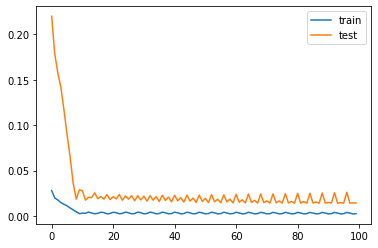

In [15]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

#### Make prediction using textX and plotting line graph against testY

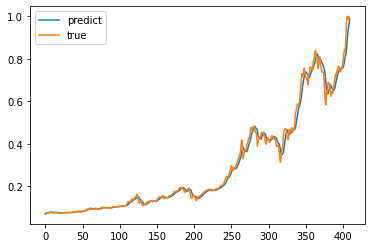

In [16]:
y_p1 = model.predict(testX)
plt.plot(y_p1, label='predict')
plt.plot(testY, label='true')
plt.legend()
plt.show()

#### Scaler Inverse Y back to normal value

In [17]:
y_p_inverse = scaler.inverse_transform(y_p1.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))

#### evaluation

In [18]:
rmse = sqrt(mean_squared_error(testY_inverse, y_p_inverse))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 132.318


#### Plot line graph with Y as USD

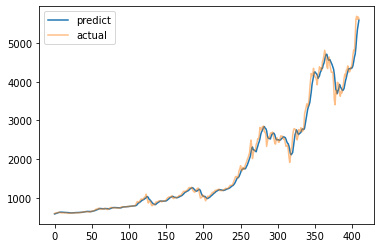

In [19]:
plt.plot(y_p_inverse, label='predict')
plt.plot(testY_inverse, label='actual', alpha=0.5)
plt.legend()
plt.show()

#### Convert X to dates

In [20]:
predictDates = data.tail(len(testX)).index

#### Reshape testY and y_pred for plotly

In [21]:
testY_reshape = testY_inverse.reshape(len(testY_inverse))
yhat_reshape = y_p_inverse.reshape(len(y_p_inverse))

#### Plot predicted and actual line graph with X=dates, Y=USD

In [22]:
actual_chart = go.Scatter(x=predictDates, y=testY_reshape, name= 'Actual Price')
predict_chart = go.Scatter(x=predictDates, y=yhat_reshape, name= 'Predict Price')
py.iplot([predict_chart, actual_chart])

# Second-Model: Using additional features for model training

#### Find corrleration in features to `Weighted Price`

<AxesSubplot:>

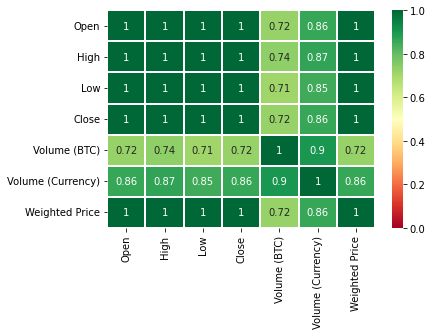

In [23]:
sns.heatmap(data.corr(), annot=True, cmap='RdYlGn', linewidths=0.1, vmin=0)

Observation: `Volume` is corrlerated to `Weighted Price`. 
`Open`, `High`, `Low`, `Close` are directly related to `Weighted Price`

#### Function to convert series to supervised learning

In [24]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

#### Get all data values

In [25]:
values = data[['Weighted Price'] + ['Volume (BTC)'] + ['Volume (Currency)']].values
values = values.astype('float32')
values[:5]

array([[8.4183551e+02, 1.5622378e+01, 1.3151473e+04],
       [8.3915625e+02, 1.9182756e+01, 1.6097329e+04],
       [8.3157294e+02, 8.1583347e+00, 6.7842500e+03],
       [8.4493878e+02, 8.0245104e+00, 6.7802202e+03],
       [8.9067169e+02, 1.8748285e+01, 1.6698566e+04]], dtype=float32)

#### Normalize features to range from 0 to 1

In [26]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(values)
scaled = scaler.transform(values)

#### Frame as supervised learning

In [27]:
reframed = series_to_supervised(scaled, 1, 1)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var1(t),var2(t),var3(t)
1,0.116909,0.000715,0.000177,0.116422,0.000878,0.000216
2,0.116422,0.000878,0.000216,0.115041,0.000373,0.000091
3,0.115041,0.000373,0.000091,0.117474,0.000367,0.000091
4,0.117474,0.000367,0.000091,0.125800,0.000858,0.000225
5,0.125800,0.000858,0.000225,0.120299,0.001164,0.000294


#### Drop unncessary columns 

In [28]:
reframed.drop(reframed.columns[[4,5]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)   var1(t)
1   0.116909   0.000715   0.000177  0.116422
2   0.116422   0.000878   0.000216  0.115041
3   0.115041   0.000373   0.000091  0.117474
4   0.117474   0.000367   0.000091  0.125800
5   0.125800   0.000858   0.000225  0.120299


#### Split data to 70% training, 30% testing

In [29]:
values = reframed.values
n_train_hours = int(len(values) * 0.7)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(965, 1, 3) (965,) (414, 1, 3) (414,)


## Training the LSTM model-2

In [30]:
multi_model = Sequential()
multi_model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
multi_model.add(Dense(1))
multi_model.compile(loss='mae', optimizer='adam')
multi_history = multi_model.fit(train_X, train_y, epochs=100, batch_size=100, validation_data=(test_X, test_y), verbose=1, shuffle=False)

Epoch 1/100
10/10 [==============================] - 2s 63ms/step - loss: 0.0310 - val_loss: 0.2487
Epoch 2/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0238 - val_loss: 0.2242
Epoch 3/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0230 - val_loss: 0.2127
Epoch 4/100
10/10 [==============================] - 0s 8ms/step - loss: 0.0217 - val_loss: 0.2085
Epoch 5/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0209 - val_loss: 0.2031
Epoch 6/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0204 - val_loss: 0.1941
Epoch 7/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0202 - val_loss: 0.1842
Epoch 8/100
10/10 [==============================] - 0s 6ms/step - loss: 0.0195 - val_loss: 0.1773
Epoch 9/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0189 - val_loss: 0.1691
Epoch 10/100
10/10 [==============================] - 0s 6ms/step - loss: 0.0185 - val_loss: 0.1583
Epoch 11

Epoch 83/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0019 - val_loss: 0.0248
Epoch 84/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0016 - val_loss: 0.0254
Epoch 85/100
10/10 [==============================] - 0s 9ms/step - loss: 0.0022 - val_loss: 0.0225
Epoch 86/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0023 - val_loss: 0.0174
Epoch 87/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0022 - val_loss: 0.0128
Epoch 88/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0048 - val_loss: 0.0149
Epoch 89/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0031 - val_loss: 0.0171
Epoch 90/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0019 - val_loss: 0.0266
Epoch 91/100
10/10 [==============================] - 0s 9ms/step - loss: 0.0019 - val_loss: 0.0276
Epoch 92/100
10/10 [==============================] - 0s 9ms/step - loss: 0.0033 - val_loss: 0.0272


#### Plot line graph to show amount loss according the the epoch

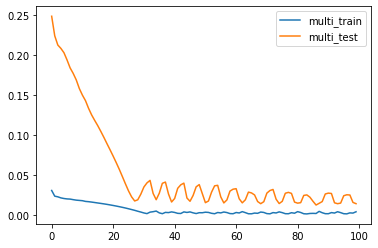

In [31]:
plt.plot(multi_history.history['loss'], label='multi_train')
plt.plot(multi_history.history['val_loss'], label='multi_test')
plt.legend()
plt.show()

#### Make prediction using textX and plotting line graph against testY

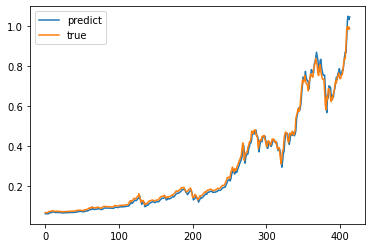

In [32]:
yhat = multi_model.predict(test_X)
plt.plot(yhat, label='predict')
plt.plot(test_y, label='true')
plt.legend()
plt.show()

#### Scaler Inverse Y back to normal value

In [33]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

#### RMSE

In [34]:
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 106.894


# Final result

#### Plot line graph with actual price, predicted price with feature `Weighted Price`, predicted price with features `Volume` and `Weighted Price`

In [35]:
actual_chart = go.Scatter(x=predictDates, y=inv_y, name= 'Actual Price')
multi_predict_chart = go.Scatter(x=predictDates, y=inv_yhat, name= 'Multi Predict Price')
predict_chart = go.Scatter(x=predictDates, y=yhat_reshape, name= 'Predict Price')
py.iplot([predict_chart, multi_predict_chart, actual_chart])

In [36]:
w_p = 500
vol_bt = 30
vol_c = 100
input_array = np.array([[w_p,vol_bt,vol_c]])
input_array = scaler.transform(input_array.reshape(1, -1))
pred = multi_model.predict(input_array.reshape(1,1,3))[0][0]
out = scaler.inverse_transform(np.array([[pred,0.0,0.0]]).reshape(1, -1))[0][0]
print(f"the Bit coin price is: {out} USD")

the Bit coin price is: 474.87572501515 USD


In [37]:
def output():
    global fr,fr1
    w_p = float(e1.get())
    vol_bt = float(e1.get())
    vol_c = float(e1.get())
    input_array = np.array([[w_p,vol_bt,vol_c]])
    input_array = scaler.transform(input_array.reshape(1, -1))
    pred = multi_model.predict(input_array.reshape(1,1,3))[0][0]
    out = scaler.inverse_transform(np.array([[pred,0.0,0.0]]).reshape(1, -1))[0][0]
    ot = f"The Bit coin price is:\n{out} USD"
    print(ot)
    e1.delete(0,END)
    e2.delete(0,END)
    e3.delete(0,END)
    fr.pack_forget()
    
    fr1 = Frame(height = 400, width = 400 )
    fr1.pack()
    
    Label(fr1,text="Predicted Price of the Bit Coin",font = "bold, 14",bg="purple").pack(fill="x",ipady=3,expand=True)
    
    Label(fr1,text = ot,font = "bold, 14").pack(ipady=3,pady=50,expand=True)
    
    Button(fr1,text="@ Try New",command=lambda : not fr.pack() and fr1.pack_forget()).pack()

In [ ]:
from tkinter import *
root = Tk()
root.title("Bit Coin Price Prediction")
root.geometry("400x400")

fr = Frame(height = 400, width = 400 )
fr.pack(fill="x")

Label(fr,text="Bit Coin Price Prediction",font = "bold, 14",bg="purple").pack(fill="x",ipady=3,expand=True)
Label(fr).pack()
Label(fr).pack()
Label(fr, text = "weighted price", font = "bold, 14").pack(pady=5)

e1 = Entry(fr, font = "bold, 14")
e1.pack(pady=5)

Label(fr, text = "Volume(BTC)", font = "bold, 16").pack(pady=5)

e2 = Entry(fr, font = "bold, 14")
e2.pack(pady=5)

Label(fr, text = "Volume(Currency)", font = "bold, 16").pack(pady=5)

e3 = Entry(fr, font = "bold, 14")
e3.pack(pady=5)

Button(fr, text = "Submit",command = output,bg = "purple", fg = "white",font = "bold, 14").pack(pady=15)
root.mainloop()

The Bit coin price is:
85.04116520093548 USD
The Bit coin price is:
29341.253671908617 USD
